# Building and Training CNNs for Image Classification

## Project Outline
#### This project covers:
* Crafting a custom dataset in PyTorch for training, validation, and testing purposes.
* Constructing a Convolutional Neural Network (CNN) using PyTorch.
* Training and evaluating your CNN within the PyTorch framework.

## Stage 1. Writing a Custom Dataset for Fashion-MNIST

### Part 1.1. Define a Dataset Class
Here, we define a custom dataset by extending the PyTorch [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class. This allows for flexible data handling and integration with PyTorch's data loading utilities.

In [11]:
!pip install onedrivedownloader

In [12]:
from onedrivedownloader import download
import os
link = 'https://unioulu-my.sharepoint.com/:u:/g/personal/sjodeiri24_student_oulu_fi/ERSM9H9tfKFAukfqZl6E1UABUthgXNMgxmt7rLOcEejXCg?e=bwILXC'

if not os.path.exists('./data/fashion_mnist_npy'):
    print('Downloading dataset')
    download(link, filename="./fashion_mnist_npy", unzip=True, unzip_path='./data/fashion_mnist_npy')


  0%|          | 0.00/30.6M [00:00<?, ?iB/s]
  0%|          | 12.3k/30.6M [00:00<05:12, 98.1kiB/s]
  0%|          | 61.4k/30.6M [00:00<01:55, 265kiB/s] 
  0%|          | 143k/30.6M [00:00<01:42, 297kiB/s] 
  1%|          | 274k/30.6M [00:00<00:58, 519kiB/s]
  2%|▏         | 537k/30.6M [00:00<00:30, 981kiB/s]
  3%|▎         | 799k/30.6M [00:01<00:37, 805kiB/s]
  6%|▌         | 1.72M/30.6M [00:01<00:16, 1.76MiB/s]
  9%|▊         | 2.63M/30.6M [00:01<00:09, 2.82MiB/s]
 12%|█▏        | 3.55M/30.6M [00:01<00:07, 3.76MiB/s]
 15%|█▍        | 4.47M/30.6M [00:01<00:05, 4.56MiB/s]
 18%|█▊        | 5.39M/30.6M [00:01<00:04, 5.21MiB/s]
 21%|██        | 6.30M/30.6M [00:02<00:04, 5.72MiB/s]
 27%|██▋       | 8.14M/30.6M [00:02<00:02, 8.05MiB/s]
 33%|███▎      | 9.97M/30.6M [00:02<00:02, 9.77MiB/s]
 39%|███▊      | 11.8M/30.6M [00:02<00:01, 11.0MiB/s]
 45%|████▍     | 13.6M/30.6M [00:02<00:01, 11.9MiB/s]
 54%|█████▎    | 16.4M/30.6M [00:02<00:00, 14.7MiB/s]
 58%|█████▊    | 17.9M/30.6M [00:02<00:01, 

Unzipping file...



Extracting files: 100%|██████████| 4/4 [00:00<00:00, 11.60it/s]


In [13]:
# import necessary packages
import os
import torch
import requests, zipfile, sys
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms


# fashion_MNIST dataset
data_dir='./data/fashion_mnist_npy/'
train_data = np.load(os.path.join(data_dir, 'train_data.npy'))
test_data = np.load(os.path.join(data_dir, 'test_data.npy'))
train_label = np.load(os.path.join(data_dir, 'train_labels.npy'))
test_label = np.load(os.path.join(data_dir, 'test_labels.npy'))

print(len(train_label))
# split the training data to a new training data and validation data
class_indices = [[] for i in range(10)]
for i, v in enumerate(train_label):
    class_indices[v].append(i)

indices_all = np.random.permutation(len(class_indices[0]))
# take the first 1000 indices of indices_all
indices = indices_all[:1000]
# take the rest of the indices of indices_all
indices_rest = indices_all[1000:]

valid_indices = []
train_indices = []
for i in range(10):
    # build indices for validation set
    valid_indices.extend(np.array(class_indices[i])[indices])
    train_indices.extend(np.array(class_indices[i])[indices_rest])
# write the custom dataset based on the dataset
class FashionMnist(Dataset):
    """Fashion Mnist dataset"""

    def __init__(self, phase='train', transform=None):

        if 'train' == phase:
            self.data = train_data[train_indices]
            self.label = train_label[train_indices]

        elif 'valid' == phase:
            self.data = train_data[valid_indices]
            self.label = train_label[valid_indices]

        elif 'test' == phase:
            self.data = test_data
            self.label = test_label

        else:
            assert True, 'wrong phase'


        self.transform = transform
        self.label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt','Sneaker','Bag','Ankle boot']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        img, label = self.data[index], self.label[index]
        # to return a PIL Image
        img = Image.fromarray(img, mode='L')

        if self.transform is not None:
            img = self.transform(img)

        return img, label


60000


### Part 1.2. Dataset Inspection
This step involves verifying the dataset's integrity. First, we display a random selection of images from the training, validation, and testing sets to visually confirm the correctness of labels. Secondly, we examine the class distribution within each dataset split to ensure balanced representation.

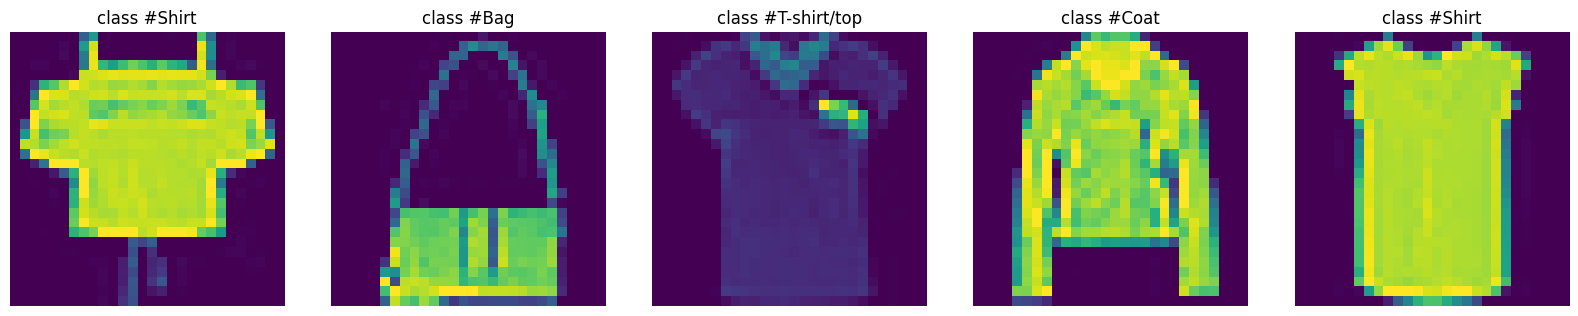

total number of training set: 50000
numer of images for class T-shirt/top: 5000
numer of images for class Trouser: 5000
numer of images for class Pullover: 5000
numer of images for class Dress: 5000
numer of images for class Coat: 5000
numer of images for class Sandal: 5000
numer of images for class Shirt: 5000
numer of images for class Sneaker: 5000
numer of images for class Bag: 5000
numer of images for class Ankle boot: 5000


In [14]:
# checking training set
# randomly show some samples and their labels
train_set = FashionMnist(phase='train', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(train_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = train_set[idx[i]]
    label_name = train_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image))

plt.show()

# print number of images for each class
print('total number of training set: {}'.format(len(train_set)))
for i in range(10):
    print('numer of images for class {}: {}'.format(train_set.label_names[i], np.sum(train_set.label==i)))

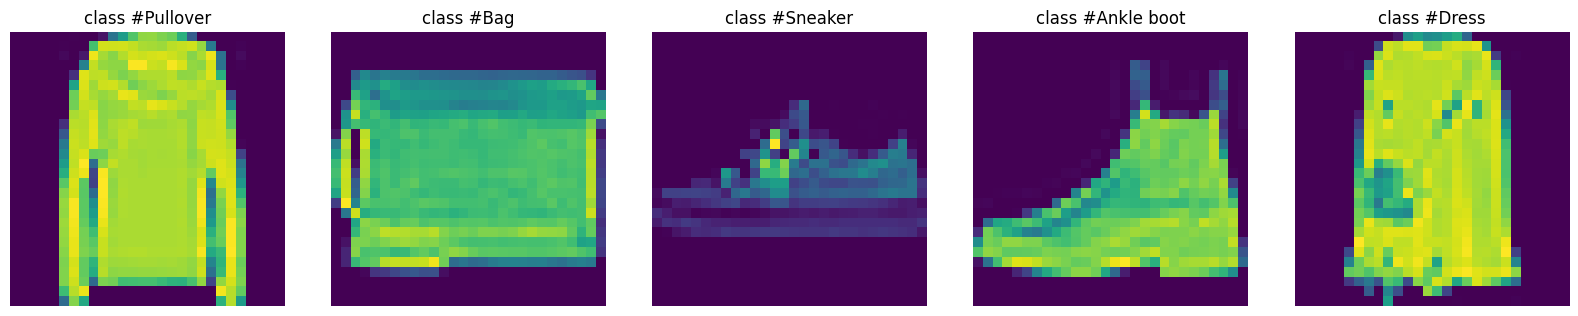

total number of validation set: 10000
numer of images for class T-shirt/top: 1000
numer of images for class Trouser: 1000
numer of images for class Pullover: 1000
numer of images for class Dress: 1000
numer of images for class Coat: 1000


In [15]:
# checking validation data
validation_set = FashionMnist(phase='valid', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(validation_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = validation_set[idx[i]]
    label_name = validation_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image))

plt.show()

print('total number of validation set: {}'.format(len(validation_set)))
for i in range(5):
    print('numer of images for class {}: {}'.format(validation_set.label_names[i], np.sum(validation_set.label==i)))

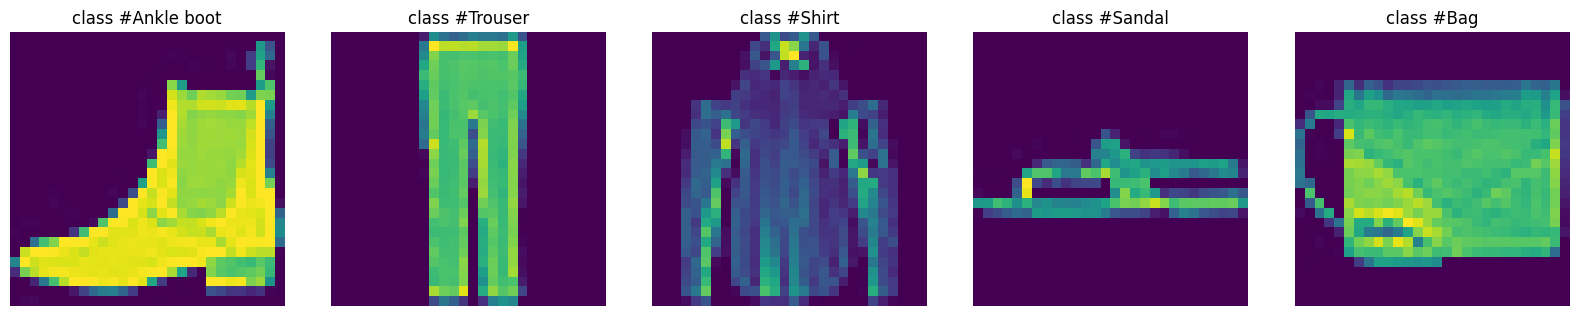

total number of testing set: 10000
numer of images for class T-shirt/top: 1000
numer of images for class Trouser: 1000
numer of images for class Pullover: 1000
numer of images for class Dress: 1000
numer of images for class Coat: 1000
numer of images for class Sandal: 1000
numer of images for class Shirt: 1000
numer of images for class Sneaker: 1000
numer of images for class Bag: 1000
numer of images for class Ankle boot: 1000


In [16]:
# checking testing data
testing_set = FashionMnist(phase='test', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(testing_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = testing_set[idx[i]]
    label_name = testing_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image))

plt.show()

print('total number of testing set: {}'.format(len(testing_set)))
for i in range(10):
    print('numer of images for class {}: {}'.format(testing_set.label_names[i], np.sum(testing_set.label==i)))


### Part 1.3. Dataset Iteration with Batches
To optimize training, we use PyTorch's [DataLoader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#iterating-through-the-dataset) for efficient data handling. `DataLoader` provides:
* Data batching for parallel processing.
* Data shuffling to improve training generalization.
* Parallel data loading using multiprocessing workers for faster input pipeline.

`torch.utils.data.DataLoader` efficiently manages dataset iteration.  A `FashionMnist` dataset instance from Part 1.1 is input to `DataLoader`.  A `transform` is used to convert PIL images to torch.Tensor format.  `transform` can also be used for data augmentation, further illustrated in [https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#writing-custom-datasets-dataloaders-and-transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#writing-custom-datasets-dataloaders-and-transforms).

In [17]:
# Set batch_size to 64, shuffling the training set.
data_transform = transforms.Compose([transforms.ToTensor()])

train_set = FashionMnist(phase='train', transform=data_transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)

valid_set = FashionMnist(phase='valid', transform=data_transform)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0)

test_set = FashionMnist(phase='test', transform=data_transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)

## Part 2. Constructing a CNN Model
This section details the construction of a Convolutional Neural Network (CNN). The CNN architecture includes convolutional layers (Conv), Batch Normalization layers (BN), max pooling layers (Max_pool), and fully connected layers (FC). The model is designed to process input batches of size 64.
<!--![model.png](attachment:model.png)-->
<img src=https://raw.githubusercontent.com/marukosan93/DL2024_resources/refs/heads/master/CNN.png width="800">

When defining a custom Network in PyTorch, follow these guidelines:
1. Layer definitions are placed within the `__init__` method.
2. The `forward` method contains the forward pass computation.

In [18]:
import torch
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(-1, 64 * 5 * 5)

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x


## Part 3. CNN Model Training and Testing
### Part 3.1. Define Training and Evaluation Functions
This section establishes functions for training and evaluating the CNN model.
* A network instance is initialized.
* During training, an optimizer is set up to manage network parameters, loss computation, and accuracy calculation.
* During evaluation, only accuracy calculation is performed.

In [19]:
# instantiate a network
net = Network(num_classes=10)

# evaluation function
def eval(net, data_loader):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        outs = net(images)
        preds = outs.argmax(dim=1)
        correct += preds.eq(labels).sum()
        num_images += len(labels)

    acc = correct / num_images
    return acc

# training function
def train(net, train_loader, valid_loader):
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()

    epoches = 10
    for epoch in range(epoches):
        net.train()
        correct = 0.0
        num_images = 0.0
        for i_batch, (images, labels) in enumerate(train_loader):
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()
            outs = net(images)
            loss = loss_function(outs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            preds = outs.argmax(dim=1)
            correct += preds.eq(labels).sum().item()
            num_images += len(labels)

        acc = correct / num_images
        acc_eval = eval(net, valid_loader)
        print('epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f' % (epoch, optimizer.param_groups[0]['lr'], acc, loss.item(), acc_eval))

    return net

### Part 3.2. Model Training and Performance Evaluation

In [20]:
print('Please wait patiently, it may take some seconds...')
TrainedNet=train(net, train_loader, valid_loader)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)
acc_test = eval(TrainedNet, test_loader)

print('accuracy on testing data: %f' % acc_test)

Please wait patiently, it may take some seconds...
epoch: 0, lr: 0.010000, accuracy: 0.841140, loss: 0.261318, valid accuracy: 0.875300
epoch: 1, lr: 0.010000, accuracy: 0.888000, loss: 0.151109, valid accuracy: 0.892800
epoch: 2, lr: 0.010000, accuracy: 0.903420, loss: 0.123861, valid accuracy: 0.890000
epoch: 3, lr: 0.010000, accuracy: 0.914300, loss: 0.088664, valid accuracy: 0.901600
epoch: 4, lr: 0.010000, accuracy: 0.922920, loss: 0.347979, valid accuracy: 0.908300
epoch: 5, lr: 0.010000, accuracy: 0.928780, loss: 0.106026, valid accuracy: 0.902200
epoch: 6, lr: 0.010000, accuracy: 0.936920, loss: 0.115722, valid accuracy: 0.907200
epoch: 7, lr: 0.010000, accuracy: 0.941820, loss: 0.342238, valid accuracy: 0.911900
epoch: 8, lr: 0.010000, accuracy: 0.946880, loss: 0.129164, valid accuracy: 0.912600
epoch: 9, lr: 0.010000, accuracy: 0.953140, loss: 0.019888, valid accuracy: 0.908100
accuracy on testing data: 0.902400
